In [50]:
# 기본 라이브러리
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# geopy 지리 정보 만들기 위한 라이브러리
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.distance import great_circle
import folium
from folium.features import CustomIcon
from folium.plugins import MarkerCluster
import geopy

# 인코딩을 위한 라벨인코딩
from sklearn.preprocessing import LabelEncoder

# linear 모델 돌리기 위한 라이브러리
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet

# 랜덤포레스트 돌리기 위한 라이브러리
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import random

# 부스팅 모델 돌리기 위한 라이브러리
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

In [51]:
# 이거는 자꾸 맷플롯립 그래프에서 한글이 깨지는 문제로 폰트 설치해주는 코드

from matplotlib import font_manager, rc

font = r"C:\Users\thinp\fonts\NanumGothic.ttf"
font = font_manager.FontProperties(fname=font).get_name()
plt.style.use('seaborn-white')
rc('font', family=font)

In [52]:
bus_train = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\data\bus\train.csv")
bus_test = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\data\bus\test.csv")

In [53]:
bus_bts = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\data\bus\bus_bts.csv")

In [54]:
raining = pd.read_csv(r"C:\Users\thinp\python\Kaggle\jeju_bus\weather.csv") # 기상청에서 가져온 데이터

In [55]:
bus_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

## 1. 내부 데이터 전처리

### 1.1 전처리: date 값 변환

In [56]:
def pre_date(bus_train, bus_test):
    # "date" 칼럼을 판다스의 datetime으로 바꿔줍니다. from 구글링.
    bus_train['date2'] = pd.to_datetime(bus_train['date'], errors='coerce')
    bus_test['date2'] = pd.to_datetime(bus_test['date'], errors='coerce')
    
    # 일을 나타내는 새로운 컬럼을 생성합니다.
    # 년,월은 의미가 없습니다.
    bus_train["date_day"] = bus_train["date2"].dt.day
    bus_test["date_day"] = bus_test["date2"].dt.day
    
    # dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
    # 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
    bus_train["date-dayofweek"] = bus_train["date2"].dt.dayofweek
    bus_test["date-dayofweek"] = bus_test["date2"].dt.dayofweek
    
    
    # 다 쓴 "date2" 칼럼 버리기
    bus_train.drop("date2", axis=1, inplace=True)
    bus_test.drop("date2", axis=1, inplace=True)
    
    return bus_train, bus_test

### 1.2 전처리: in_out 값 변환

In [57]:
def pre_inout(bus_train, bus_test):
    # 시내는 0 시외는 1로 바꿔준다.
    bus_train['in_out'] = bus_train['in_out'].map({'시내':0,'시외':1})
    bus_test['in_out'] = bus_test['in_out'].map({'시내':0,'시외':1})
    
    return bus_train, bus_test

### 1.3 전처리: ride, off 값 합쳐주기

In [58]:
def pre_time(bus_train, bus_test):
    # y값이 2시간 단위이니 x값도 2시간으로 합쳐줍니다.
    bus_train['6~8_on']=bus_train['6~7_ride']+bus_train['7~8_ride'] 
    bus_train['8~10_on']=bus_train['8~9_ride']+bus_train['9~10_ride']
    bus_train['10~12_on']=bus_train['10~11_ride']+bus_train['11~12_ride']

    bus_train['6~8_off']=bus_train['6~7_takeoff']+bus_train['7~8_takeoff'] 
    bus_train['8~10_off']=bus_train['8~9_takeoff']+bus_train['9~10_takeoff']
    bus_train['10~12_off']=bus_train['10~11_takeoff']+bus_train['11~12_takeoff']

    bus_test['6~8_on']=bus_test['6~7_ride']+bus_test['7~8_ride']
    bus_test['8~10_on']=bus_test['8~9_ride']+bus_test['9~10_ride']
    bus_test['10~12_on']=bus_test['10~11_ride']+bus_test['11~12_ride']

    bus_test['6~8_off']=bus_test['6~7_takeoff']+bus_test['7~8_takeoff']
    bus_test['8~10_off']=bus_test['8~9_takeoff']+bus_test['9~10_takeoff']
    bus_test['10~12_off']=bus_test['10~11_takeoff']+bus_test['11~12_takeoff']
    
    # 기존 시간변수들은 drop 해줍니다.
    bus_train.drop(["6~7_ride", "7~8_ride", "8~9_ride", "9~10_ride", "10~11_ride", "11~12_ride",
                   "6~7_takeoff", "7~8_takeoff", "8~9_takeoff", "9~10_takeoff", "10~11_takeoff", "11~12_takeoff"], axis=1, inplace=True)
    bus_test.drop(["6~7_ride", "7~8_ride", "8~9_ride", "9~10_ride", "10~11_ride", "11~12_ride",
                   "6~7_takeoff", "7~8_takeoff", "8~9_takeoff", "9~10_takeoff", "10~11_takeoff", "11~12_takeoff"], axis=1, inplace=True)
    
    return bus_train, bus_test

### 1.9 적용

In [59]:
tr, te = pre_date(bus_train, bus_test)
tr, te = pre_inout(tr, te)
tr, te = pre_time(tr, te)

tr.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,date_day,date-dayofweek,6~8_on,8~10_on,10~12_on,6~8_off,8~10_off,10~12_off
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1,6,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,5.0,1,6,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,1,6,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,53.0,1,6,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,1,6,0.0,0.0,0.0,0.0,1.0,0.0


## 2. EDA

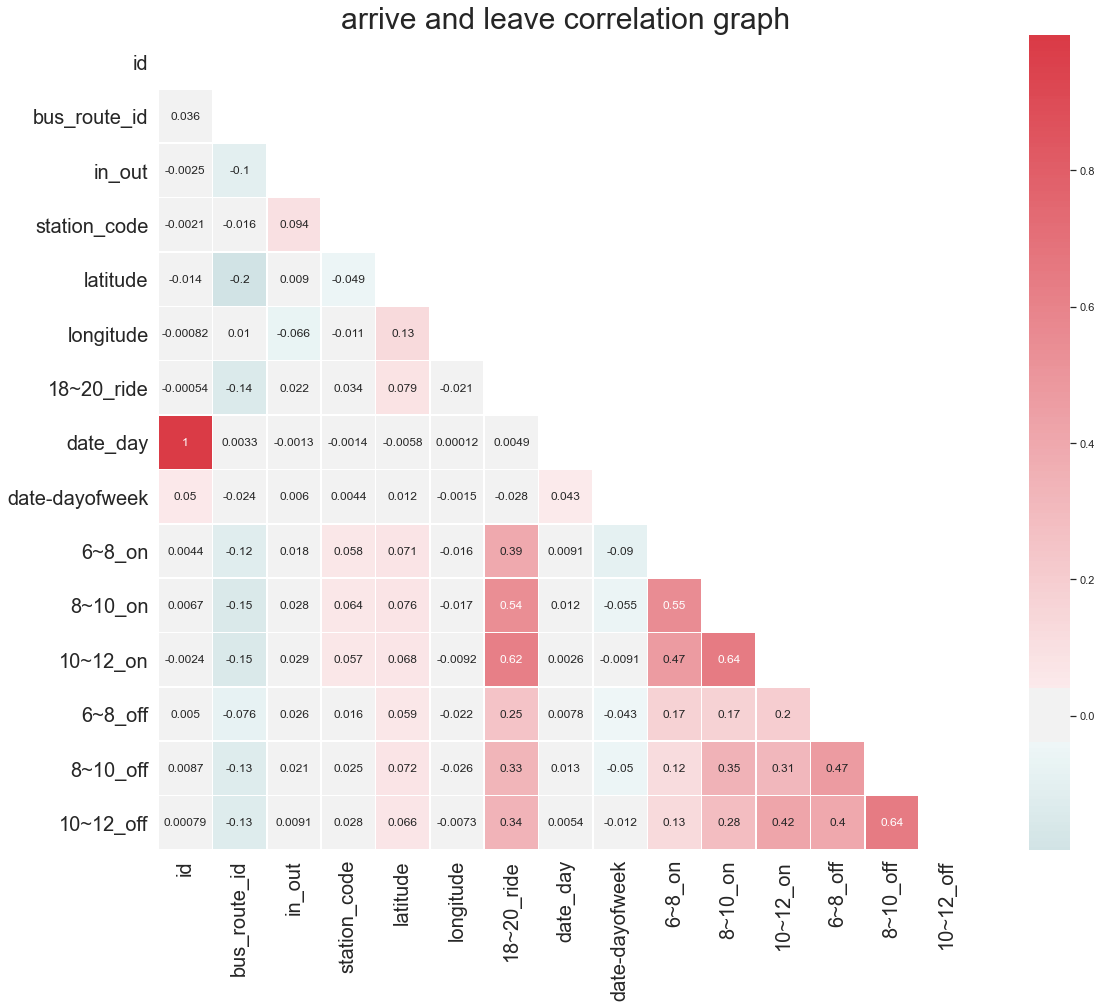

In [60]:
# 칼럼별로 상관관계를 살펴봅시다.

cor=tr.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

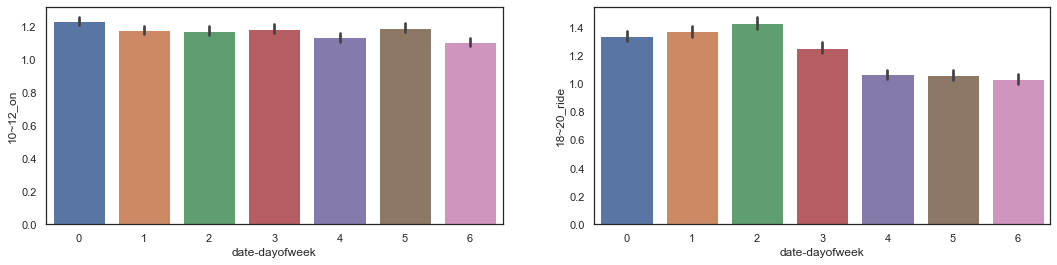

In [66]:
# 날짜별, 요일별 하차인원 차이를 알아봅시다.

# 2x2으로 총 4개의 시각화를 한 화면에 띄웁니다.
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)

# 시각화의 전체 사이즈는 18x8로 설정합니다.
figure.set_size_inches(18, 4)

sns.barplot(data=tr, x="date-dayofweek", y="10~12_on", ax=ax1)
sns.barplot(data=tr, x="date-dayofweek", y="18~20_ride", ax=ax2)

값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다. 10-12시 탑승객에 비해 18-20 탑승객은 차이가 다소 있습니다.
    - 월요일-수요일까지는 탑승객 수가 증가합니다.
    - 목요일부터 하락하기 시작해서 금,토,일요일은 차이가 다소 납니다.

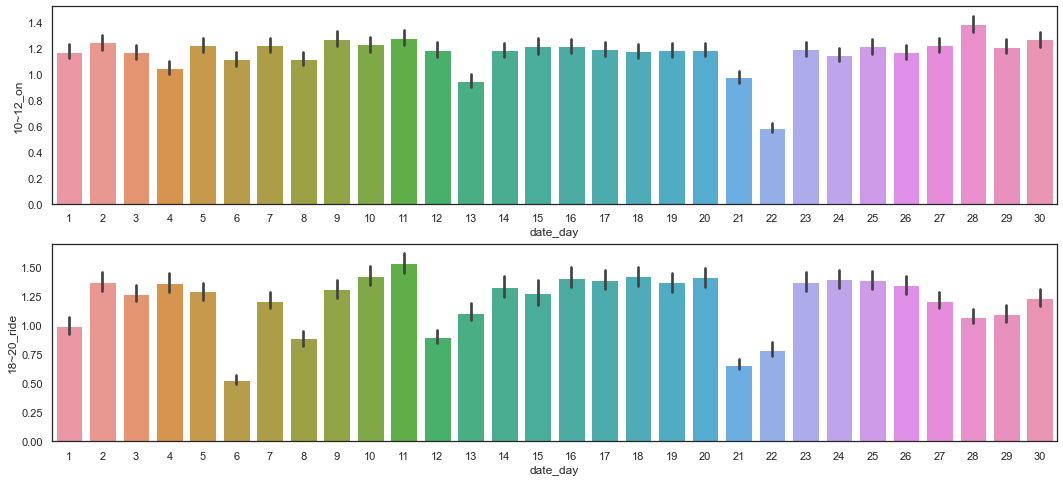

In [65]:
# 날짜별, 요일별 하차인원 차이를 알아봅시다.

# 2x2으로 총 4개의 시각화를 한 화면에 띄웁니다.
figure, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1)

# 시각화의 전체 사이즈는 18x8로 설정합니다.
figure.set_size_inches(18, 8)

sns.barplot(data=tr, x="date_day", y="10~12_on", ax=ax1)
sns.barplot(data=tr, x="date_day", y="18~20_ride", ax=ax2)

날짜별로도 차이가 다소 느껴집니다. 2019년 9월의 달력을 살펴보겠습니다.
    - 1일은 일요일이었습니다.
    - 6일은 금요일이었습니다. 차이가 많이 납니다.
    - 8일은 일요일이었습니다.
    - 12일은 목요일이면서 추석연휴의 시작입니다. 추석은 14일까지 이어집니다.
    - 14일은 추석연휴이자 토요일임에도 18-20탑승객이 많습니다. 이는 15일 일요일도 마찬가지입니다.
    - 21일은 토요일입니다.
    - 29일도 토요일입니다.

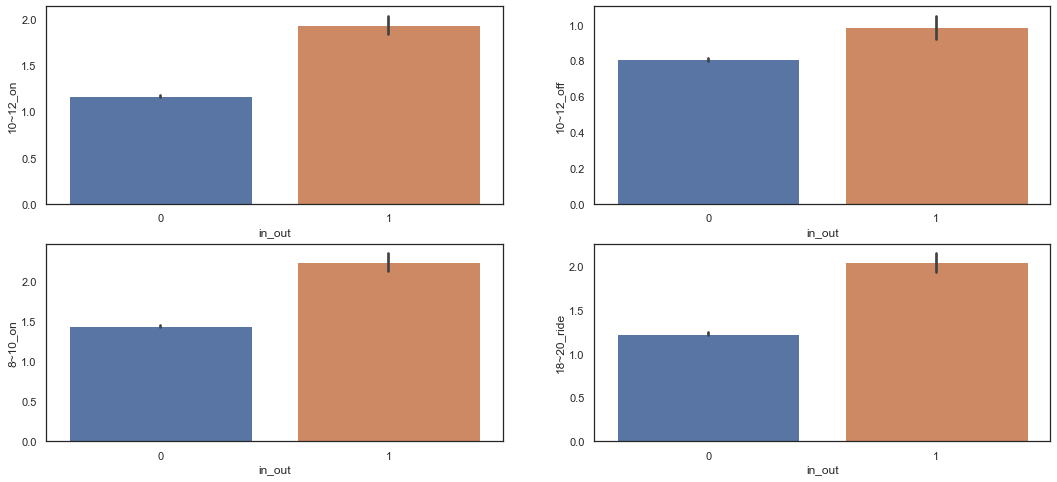

In [67]:
# 시내외 버스 여부를 확인해볼까요?

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

figure.set_size_inches(18, 8)

sns.barplot(data=tr, x="in_out", y="10~12_on", ax=ax1) 
sns.barplot(data=tr, x="in_out", y="10~12_off", ax=ax2) 
sns.barplot(data=tr, x="in_out", y="8~10_on", ax=ax3) 
sns.barplot(data=tr, x="in_out", y="18~20_ride", ax=ax4)

시내는 0 시외는 1로 변환해주었습니다. 이 비율은 크게 차이가 보이지는 않습니다.

## 3. 모델링

In [ ]:
tr.info()

In [ ]:
def pre_encode(bus_train, bus_test):
    # 원핫인코딩 진행해줍니다.
    bus_train = pd.get_dummies(bus_train,columns=['date-dayofweek'],prefix='wd_')
    bus_test = pd.get_dummies(bus_test,columns=['date-dayofweek'],prefix='wd_')
    
    # 의미없는 칼럼 날려줍니다.
    bus_train.drop(["date", "station_name", "date_day"], axis=1, inplace=True)
    bus_test.drop(["date", "station_name", "date_day"], axis=1, inplace=True)
    
    return bus_train, bus_test

In [ ]:
tr_pre_encode, te_pre_encode = pre_encode(tr, te)

In [ ]:
tr_pre_encode.columns

In [ ]:
# 독립변수들을 정해줍니다.
features=['id', 'bus_route_id', 'in_out', 'station_code', 'latitude', 'longitude',
       '6~8_on', '8~10_on', '10~12_on', '6~8_off', '8~10_off',
       '10~12_off', 'wd__0', 'wd__1', 'wd__2', 'wd__3', 'wd__4', 'wd__5',
       'wd__6']

# 18~20ride 를 label로 지정합니다.
label = "18~20_ride"

### Linear Regression

In [154]:
# lr 모델들은 스케일링을 해줍니다.

scaler = StandardScaler()
tr_scaled = scaler.fit_transform(tr_pre_encode.values)
te_scaled = scaler.fit_transform(te_pre_encode.values)
tr_scaled2 = pd.DataFrame(tr_scaled, index=tr_pre_encode.index, columns=tr_pre_encode.columns)
te_scaled2 = pd.DataFrame(te_scaled, index=te_pre_encode.index, columns=te_pre_encode.columns)

In [155]:
# train, test 셋을 세팅해줍니다.
X_train = tr_scaled2[features]
X_test = te_scaled2[features]
y_train = tr_scaled2[label]

X_train.shape, y_train.shape, X_test.shape

((415423, 19), (415423,), (228170, 19))

In [156]:
lr_pre = linear_model.LinearRegression()
model_pre = lr_pre.fit(X_train, y_train)

print(lr_pre.coef_)
print(model_pre.score(X_train, y_train))

[ 5.50148909e-04 -2.44071772e-02 -2.61600631e-03 -8.59280026e-03
  1.68887170e-02 -1.18070919e-02  6.95880584e-02  1.86073513e-01
  4.09178248e-01  7.65158772e-02  7.34666431e-02  3.11741794e-02
  2.67752070e+10  2.47262063e+10  2.44621648e+10  2.39953618e+10
  2.34245915e+10  2.14882921e+10  2.28446718e+10]
0.43959222869949166


### Elastic Net

In [69]:
# Create the parameter grid based on the results of random search 
param_grid = {'alpha': [0.1,1,10],
              'l1_ratio': [0.1, 0.3, 0.7, 0.9]
}
# Create a based model
en = ElasticNet(random_state=42) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = en, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

# {'alpha': 0.1, 'l1_ratio': 0.1}

{'alpha': 0.1, 'l1_ratio': 0.1}

In [157]:
# 규제를 줘봅니다.

en_pre = ElasticNet(alpha = 1, l1_ratio=0.1)
en_pre.fit(X_train,y_train)
en_pre.score(X_train, y_train)

0.3553151659327355

### Boosting

In [158]:
# 부스팅 모델은 다시 전체 데이터로 적용
X_train=tr_pre_encode[features]
y_train=tr_pre_encode[label]

X_test=te_pre_encode[features]

X_train.shape, y_train.shape, X_test.shape

((415423, 19), (415423,), (228170, 19))

In [161]:
gbrt_pre = GradientBoostingRegressor(max_depth = 2,
                                     n_estimators= 20,
                                     learning_rate=0.5,)
gbrt_pre.fit(X_train,y_train)
gbrt_pre.score(X_train, y_train)

0.48214114551665976

#### Random Forest Regressor

In [162]:
rf_pre = RandomForestRegressor(max_features=3,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=20)

rf_pre.fit(X_train,y_train)
rf_pre.score(X_train, y_train)

0.8504220129592986

랜덤 포레스트가 압도적으로 높은 성능을 내고 있습니다. 85%는 심지어 나쁜 스코어가 아니니 랜덤 포레스트로 파라미터 튜닝을 들어가겠습니다.

## 4. 파생변수생성

### 4.0 외부 데이터 준비

In [68]:
# geopy 데이터를 만들어줍니다.
# 본 데이터는 기상청 측정소를 기준으로 정류장을 맵핑해주기 위함이며, 마찬가지로 기상 데이터의 정확도를 높이기 위함입니다.

# 해당 주요 장소의 임의 지역 위도, 경도
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()
    
#각 주요 장소에 마커 추가
mc.add_child(folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) 
#마커를 map_osm에 추가
map_osm.add_child(mc) 

mc.add_child(folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child(folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child(folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

#정류장의 위치만 확인하기 위해 groupby를 실행함
flag_data=bus_train[['latitude','longitude','station_name']].drop_duplicates(keep='first')
flag_data2=flag_data.groupby(['station_name'])['latitude','longitude'].mean()
flag_data2.to_csv("folium.csv")
flag_data2=pd.read_csv("folium.csv")

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [69]:
# rain 데이터를 만들어줍니다.

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [str(i) for i in raining['지점']]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점']]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점']]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점']]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점']]  # 위도 : 33.24616 경도 : 126.5653

raining["강수량(mm)"].fillna(value=0, inplace=True)
raining["풍속(m/s)"].fillna(value=0, inplace=True)

# data merge를 위하여, 일시와 시간대를 분리
raining['time'] = [int( i.split(' ')[1].split(':')[0]) for i in raining['일시']] 

raining['일시'] = [i.split(' ')[0] for i in raining['일시']] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[(raining['time']>12)]

# 해당 시간대의 평균 기온 및 강수량을 변수로 사용할 예정이기 때문에, groupby를 실행

rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)','풍속(m/s)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

### 4.2 휴일 여부 칼럼 생성

In [70]:
def add_holiday(bus_train, bus_test):
    # 9월 10월에 공휴일이 있었습니다. 공휴일은 holiday 칼럼을 넣어주겠습니다.
    # 다만 주말과 평일공휴일을 구분해보기 위해서 값을 다르게 줘보겠습니다.
    # 평일 공휴일은 "holiday", 주말은 "weekend", 평일은 "weekday" 로 가겠습니다.
    
    # 2019년 9월 12, 13, 14 일은 추석연휴였습니다. 14일은 참고로 토요일.
    # 2019년 9월 1,8,15,22,29 은 일요일, 7, 14, 21, 28은 토요일
    bus_train.loc[bus_train["date_day"] == 12, "date_holiday"] = "holiday"
    bus_train.loc[bus_train["date_day"] == 13, "date_holiday"] = "holiday"
    bus_train.loc[bus_train["date_day"] == 14, "date_holiday"] = "holiday"

    bus_train.loc[bus_train["date_day"] == 1, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 8, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 15, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 22, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 29, "date_holiday"] = "weekend"

    bus_train.loc[bus_train["date_day"] == 7, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 14, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 21, "date_holiday"] = "weekend"
    bus_train.loc[bus_train["date_day"] == 28, "date_holiday"] = "weekend"
    
    bus_train["date_holiday"].fillna(value="weekday",inplace=True)
    bus_train.loc[bus_train["date_holiday"] == 0, "date_holiday"] = "weekday"
    
    # 2019년 10월 3일은 개천절, 10월 9일은 한글날, 각각 목요일과 수요일.
    # 2019년 10월 3일은 개천절, 10월 9일은 한글날, 각각 목요일과 수요일.
    # 2019년 10월 5,12는 토요일, 6,13은 일요일
    bus_test.loc[bus_test["date_day"] == 3, "date_holiday"] = "holiday"
    bus_test.loc[bus_test["date_day"] == 9, "date_holiday"] = "holiday"

    bus_test.loc[bus_test["date_day"] == 5, "date_holiday"] = "weekend"
    bus_test.loc[bus_test["date_day"] == 12, "date_holiday"] = "weekend"

    bus_test.loc[bus_test["date_day"] == 6, "date_holiday"] = "weekend"
    bus_test.loc[bus_test["date_day"] == 13, "date_holiday"] = "weekend"


    bus_test["date_holiday"].fillna(value="weekday",inplace=True)
    bus_test.loc[bus_test["date_holiday"] == 0, "date_holiday"] = "weekday"
    
    return bus_train, bus_test

In [71]:
def add_holiday2(bus_train, bus_test):
    # pre_holiday2 는 holiday 칼럼에 대한 새로운 접근입니다.
    # 완벽하게 모두가 쉬는 공휴일은 off로,
    # 출근 할 가능성이 있는 poss(ible)로,
    # 완벽하게 출근 하는 날은 on 으로, 구분해보겠습니다.
    
    # 2019년 9월 12, 13, 14 일은 추석연휴였지만, 13일만 off로, 13, 14는 poss로 하겠습니다.
    # 2019년 9월 1,8,15,22,29 은 일요일, 7, 14, 21, 28은 토요일
    bus_train.loc[bus_train["date_day"] == 12, "date_holiday2"] = "poss"
    bus_train.loc[bus_train["date_day"] == 13, "date_holiday2"] = "off"
    bus_train.loc[bus_train["date_day"] == 14, "date_holiday2"] = "poss"

    bus_train.loc[bus_train["date_day"] == 1, "date_holiday2"] = "off"
    bus_train.loc[bus_train["date_day"] == 8, "date_holiday2"] = "off"
    bus_train.loc[bus_train["date_day"] == 15, "date_holiday2"] = "off"
    bus_train.loc[bus_train["date_day"] == 22, "date_holiday2"] = "off"
    bus_train.loc[bus_train["date_day"] == 29, "date_holiday2"] = "off"

    bus_train.loc[bus_train["date_day"] == 7, "date_holiday2"] = "poss"
    #bus_train.loc[bus_train["date_day"] == 14, "date_holiday2"] = "poss" # 추석 연휴에 포함됩니다.
    bus_train.loc[bus_train["date_day"] == 21, "date_holiday2"] = "poss"
    bus_train.loc[bus_train["date_day"] == 28, "date_holiday2"] = "poss"
    
    bus_train["date_holiday2"].fillna(value="on",inplace=True)
    bus_train.loc[bus_train["date_holiday2"] == 0, "date_holiday2"] = "on"
    
    # 2019년 10월 3일은 개천절, 10월 9일은 한글날, 각각 목요일과 수요일.
    # 2019년 10월 3일은 개천절, 10월 9일은 한글날, 각각 목요일과 수요일.
    # 2019년 10월 5,12는 토요일, 6,13은 일요일
    # 공휴일
    bus_test.loc[bus_test["date_day"] == 3, "date_holiday2"] = "off"
    bus_test.loc[bus_test["date_day"] == 9, "date_holiday2"] = "off"
    # 토요일
    bus_test.loc[bus_test["date_day"] == 5, "date_holiday2"] = "poss"
    bus_test.loc[bus_test["date_day"] == 12, "date_holiday2"] = "poss"
    # 일요일
    bus_test.loc[bus_test["date_day"] == 6, "date_holiday2"] = "off"
    bus_test.loc[bus_test["date_day"] == 13, "date_holiday2"] = "off"


    bus_test["date_holiday2"].fillna(value="on",inplace=True)
    bus_test.loc[bus_test["date_holiday2"] == 0, "date_holiday2"] = "on"
    
    return bus_train, bus_test

### 4.3 정류장 그룹화

In [72]:
def add_latlong(bus_train, bus_test):
    # lat과 long, route_id, station name과 code까지 엮어준다.
    bus_train['bus_route_id'] = bus_train['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    bus_test['bus_route_id'] = bus_test['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    #bus_train['station_name2'] = bus_train['station_name'].apply(lambda x: str(x)[:2])
    #bus_test['station_name2'] = bus_test['station_name'].apply(lambda x: str(x)[:2])
    #bus_train['station_name'] = bus_train['station_name'].apply(lambda x: x.replace(' ', ''))
    #bus_test['station_name'] = bus_test['station_name'].apply(lambda x: x.replace(' ', ''))

    # lat_long을 합쳐서 그룹핑을 해준다.
    bus_train['lat_long'] = np.round(bus_train['latitude'], 2).astype(str) + np.round(bus_train['longitude'], 2).astype(str)
    bus_test['lat_long'] = np.round(bus_test['latitude'], 2).astype(str) + np.round(bus_test['longitude'], 2).astype(str)
    le = LabelEncoder().fit(pd.concat([bus_train['lat_long'], bus_test['lat_long']]))
    bus_train['station_lat_long'] = le.transform(bus_train['lat_long'])
    bus_test['station_lat_long'] = le.transform(bus_test['lat_long'])

    # 좀 더 디테일하게 한 번 더 한다.
    bus_train['lat_long'] = np.round(bus_train['latitude'], 3).astype(str) + np.round(bus_train['longitude'], 2).astype(str)
    bus_test['lat_long'] = np.round(bus_test['latitude'], 3).astype(str) + np.round(bus_test['longitude'], 2).astype(str)
    le = LabelEncoder().fit(pd.concat([bus_train['lat_long'], bus_test['lat_long']]))
    bus_train['station_lat_long2'] = le.transform(bus_train['lat_long'])
    bus_test['station_lat_long2'] = le.transform(bus_test['lat_long'])

    # 루트와 코드, 그룹핑을 교차 합쳐준다.
    bus_train['bus_route_id_station_code'] = ((bus_train['bus_route_id']).astype(str) + 
                                              (bus_train['station_code']).astype(str)).astype('category')
    bus_test['bus_route_id_station_code'] = ((bus_test['bus_route_id']).astype(str) + 
                                             (bus_test['station_code']).astype(str)).astype('category')
    bus_train['bus_route_id_station_lat_long'] = ((bus_train['bus_route_id']).astype(str) +
                                                  (bus_train['station_lat_long']).astype(str)).astype('category')
    bus_test['bus_route_id_station_lat_long'] = ((bus_test['bus_route_id']).astype(str) + 
                                                 (bus_test['station_lat_long']).astype(str)).astype('category')
    
    # station_name2와 lat_long 은 인코딩도, 형변환도 불가능하니 버려줍니다.
    #bus_train.drop("station_name2", axis=1, inplace=True)
    #bus_test.drop("station_name2", axis=1, inplace=True)
    
    bus_train.drop("lat_long", axis=1, inplace=True)
    bus_test.drop("lat_long", axis=1, inplace=True)
    
    return bus_train, bus_test

### 4.4 정류장 위치 칼럼 생성

In [73]:
def add_dist(bus_train, bus_test):
    # 만들어 둔 geopy 데이터 불러옵니다.
    flag_data2=pd.read_csv("folium.csv")

    #정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
    for row in flag_data2.itertuples():
        mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
        map_osm.add_child(mc) #마커를 map_osm에 추가

    t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
    t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
    t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]
    t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( bus_train['latitude'],bus_train['longitude'] )) ]

    bus_train['dis_jeju']=t1
    bus_train['dis_gosan']=t2
    bus_train['dis_seongsan']=t3
    bus_train['dis_po']=t4

    total=pd.DataFrame(list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'])
    bus_train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

    data22=bus_train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

    t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
    t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
    t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]
    t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( bus_test['latitude'],bus_test['longitude'] )) ]

    bus_test['dis_jeju']=t1
    bus_test['dis_gosan']=t2
    bus_test['dis_seongsan']=t3
    bus_test['dis_po']=t4

    total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
    bus_test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

    bus_train.loc[bus_train["dist_name"] == 0,"dist_name"] = "jeju"
    bus_train.loc[bus_train["dist_name"] == 1,"dist_name"] = "gosan"
    bus_train.loc[bus_train["dist_name"] == 2,"dist_name"] = "seongsan"
    bus_train.loc[bus_train["dist_name"] == 3,"dist_name"] = "po"

    bus_test.loc[bus_test["dist_name"] == 0,"dist_name"] = "jeju"
    bus_test.loc[bus_test["dist_name"] == 1,"dist_name"] = "gosan"
    bus_test.loc[bus_test["dist_name"] == 2,"dist_name"] = "seongsan"
    bus_test.loc[bus_test["dist_name"] == 3,"dist_name"] = "po"

    return bus_train, bus_test

### 4.5 기상 데이터 머지

In [74]:
def add_weather(bus_train, bus_test):
    # rain 데이터를 불러옵니다.
    rain3=pd.read_csv("rain3.csv")
    
    # train, test의 변수명과 통일
    rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})

    # 최종적으로 완성이 된 외부데이터와 현재 만들어진 train, test data에 각각 merge 한다.
    bus_train=pd.merge(bus_train,rain3,how='left',on=['dist_name','date'])
    bus_test=pd.merge(bus_test,rain3,how='left',on=['dist_name','date'])
    
    bus_train.rename(columns={'풍속(m/s)':"wind",
                              "강수량(mm)":"rain",
                              "기온(°C)":"temp"}, inplace=True)
    bus_test.rename(columns={'풍속(m/s)':"wind",
                              "강수량(mm)":"rain",
                              "기온(°C)":"temp"}, inplace=True)
    
    return bus_train, bus_test

### 4.6 기상 데이터 추가 칼럼 생성

In [75]:
def add_weather2(bus_train, bus_test):
    # 강풍 주의보 : 육상에서 풍속 14m/s 이상, 그러나 이건 엄청 정말 쎈 바람이고, 보통 10m/s 이상이면 우산이 뒤집힌다.
    # 비오는 날 : 강수량이 많지 않으나 비가 온 날과 오지 않은 날을 구분해보자.
    # 체감온도 : tf＝t－4√v＋12I 이 식에서 tf는 체감온도, t는 기온, v는 풍속, I는 지표면이 받는 복사량
    # 체감온도는 복사량이 없으니, 기온-4(루트풍속) 으로 구해보자.

    # 만들 feature는 "wind_power", "rain_or_not", "feel_temp"
    
    bus_train.loc[bus_train['wind'] >= 10, "wind_power"] = 1
    bus_train.loc[bus_train['wind'] < 10, "wind_power"] = 0
    
    bus_train.loc[bus_train["rain"] == 0 , "rain_or_not"] = 0
    bus_train.loc[bus_train["rain"] > 0 , "rain_or_not"] = 1
    
    temp = bus_train["temp"]
    feel_temp = []

    for i in range(len(temp)):
        feel_temp.append(round((bus_train["temp"].iloc[i]-4*np.sqrt(bus_train['wind'].iloc[i])),1))

    bus_train["feel_temp"] = feel_temp
    
    # test 데이터에도 동일한 작업

    bus_test.loc[bus_test['wind'] >= 10, "wind_power"] = 1
    bus_test.loc[bus_test['wind'] < 10, "wind_power"] = 0

    bus_test.loc[bus_test["rain"] == 0 , "rain_or_not"] = 0
    bus_test.loc[bus_test["rain"] > 0 , "rain_or_not"] = 1

    temp = bus_test["temp"]
    feel_temp = []

    for i in range(len(temp)):
        feel_temp.append(round((bus_test["temp"].iloc[i]-4*np.sqrt(bus_test['wind'].iloc[i])),1))
    
    bus_test["feel_temp"] = feel_temp
    
    return bus_train, bus_test

In [76]:
tr, te = add_holiday(tr, te)
tr, te = add_holiday2(tr, te)
tr, te = add_latlong(tr, te)
tr, te = add_dist(tr, te)
tr, te = add_weather(tr, te)
tr, te = add_weather2(tr, te)
tr.head()

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if sys.

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,18~20_ride,date_day,...,dis_gosan,dis_seongsan,dis_po,dist_name,temp,rain,wind,wind_power,rain_or_not,feel_temp
0,0,2019-09-01,427,1,344,제주썬호텔,33.48990,126.49373,0.0,1,...,37.692766,37.713630,27.841879,jeju,22.727273,2.272727,2.318182,0.0,1.0,16.6
1,1,2019-09-01,427,1,357,한라병원,33.48944,126.48508,5.0,1,...,37.008492,38.465822,27.996179,jeju,22.727273,2.272727,2.318182,0.0,1.0,16.6
2,2,2019-09-01,427,1,432,정존마을,33.48181,126.47352,2.0,1,...,35.642126,39.259820,27.496551,jeju,22.727273,2.272727,2.318182,0.0,1.0,16.6
3,3,2019-09-01,427,0,1579,제주국제공항(600번),33.50577,126.49252,53.0,1,...,38.643401,38.386802,29.579404,jeju,22.727273,2.272727,2.318182,0.0,1.0,16.6
4,4,2019-09-01,427,0,1646,중문관광단지입구,33.25579,126.41260,0.0,1,...,23.648361,45.899140,14.269792,po,22.127273,1.627273,2.109091,0.0,1.0,16.3


## 4. 추가 EDA

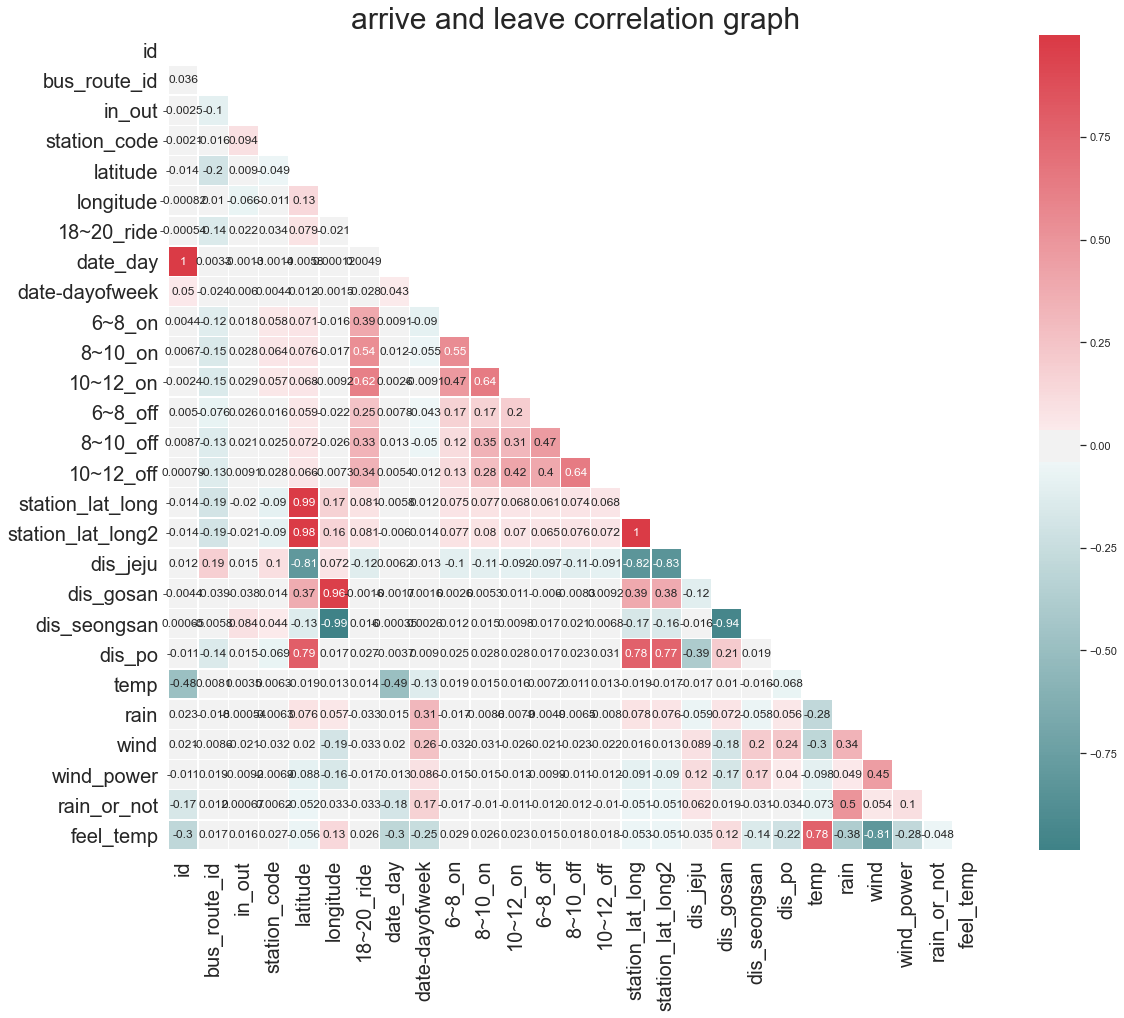

In [77]:
# 칼럼별로 상관관계를 살펴봅시다.

cor=tr.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

- date_day와 id, latitude와 longitude, latlong1과 latlong2, holiday1과 holiday2의 변수들은 강력한 양의 상관관계를 보입니다.
- 변수 삭제
    - date_day는 train data(9월)과 test data(10월)의 상관관계를 분석할 수 없으므로 date_day를 삭제해줍니다.
    - latitude와 longitude는 latlong과의 양의 상관관계가 있지만, latlong을 남기고 latitude와 longitude를 삭제해줍니다.
    
- 성능 비교
    - latlong1과 latlong2는 강력한 양의 상관관계를 보입니다. 모델 튜닝 단계에서 feature selection을 통해 성능을 비교하겠습니다.
    - holiday1과 holiday2도 모델 튜닝 단계에서 feature selection을 통해 성능을 비교하겠습니다.

In [78]:
def add_encode(bus_train, bus_test):
    # 원핫인코딩 진행해줍니다.
    bus_train = pd.get_dummies(bus_train,columns=['dist_name'])
    bus_test = pd.get_dummies(bus_test,columns=['dist_name'])
    
    bus_train = pd.get_dummies(bus_train,columns=['date_holiday'])
    bus_test = pd.get_dummies(bus_test,columns=['date_holiday'])
    bus_train = pd.get_dummies(bus_train,columns=['date_holiday2'])
    bus_test = pd.get_dummies(bus_test,columns=['date_holiday2'])
    
    bus_train = pd.get_dummies(bus_train,columns=['date-dayofweek'],prefix='wd_')
    bus_test = pd.get_dummies(bus_test,columns=['date-dayofweek'],prefix='wd_')
    
    # 의미없는 칼럼 날려줍니다.
    bus_train.drop(["date", "station_name"], axis=1, inplace=True)
    bus_test.drop(["date", "station_name"], axis=1, inplace=True)
    
    # 위에서 언급한 삭제 할 변수들을 제거해줍니다.
    bus_train.drop(["date_day", "latitude", "longitude"], axis=1, inplace=True)
    bus_test.drop(["date_day", "latitude", "longitude"], axis=1, inplace=True)
    
    return bus_train, bus_test

In [79]:
tr, te = add_encode(tr, te)
tr.head()

,id,bus_route_id,in_out,station_code,18~20_ride,6~8_on,8~10_on,10~12_on,6~8_off,8~10_off,...,date_holiday2_off,date_holiday2_on,date_holiday2_poss,wd__0,wd__1,wd__2,wd__3,wd__4,wd__5,wd__6
0,0,427,1,344,0.0,1.0,7.0,8.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,1,427,1,357,5.0,5.0,6.0,11.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,2,427,1,432,2.0,2.0,2.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,3,427,0,1579,53.0,17.0,32.0,30.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,4,427,0,1646,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1


In [117]:
tr.to_csv("tr_preprocessed_200517.csv")
te.to_csv("te_preprocessed_200517.csv")

~--------------------------------------------------------------------------------------------------------------------------~

In [125]:
tr = pd.read_csv("tr_preprocessed_200517.csv", index_col=0)
te = pd.read_csv("te_preprocessed_200517.csv", index_col=0)

In [126]:
tr.head()

,id,bus_route_id,in_out,station_code,18~20_ride,6~8_on,8~10_on,10~12_on,6~8_off,8~10_off,...,date_holiday2_off,date_holiday2_on,date_holiday2_poss,wd__0,wd__1,wd__2,wd__3,wd__4,wd__5,wd__6
0,0,427,1,344,0.0,1.0,7.0,8.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,1,427,1,357,5.0,5.0,6.0,11.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,2,427,1,432,2.0,2.0,2.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,3,427,0,1579,53.0,17.0,32.0,30.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,4,427,0,1646,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1


## 5. 모델 튜닝

In [80]:
print(tr.columns)
tr.info()

Index(['id', 'bus_route_id', 'in_out', 'station_code', '18~20_ride', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday_holiday',
       'date_holiday_weekday', 'date_holiday_weekend', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   id                             415423 non-n

### 5.1 최적의 파라미터 값 추출

In [81]:
# 전체 칼럼을 넣어줍니다.
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday_holiday',
       'date_holiday_weekday', 'date_holiday_weekend', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

In [82]:
X_train=tr[features]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=tr[features]
X_train=X_train.iloc[train_list,:]
y_train=tr[label]
y_train=y_train.iloc[train_list,:]

X_test=te[features]

X_train.shape, y_train.shape

((4154, 41), (4154, 1))

In [83]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 5분 소요

#{'max_features': 5,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 200}

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\sklearn\model_selection\_validation

{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

### 5.2 변수별 모델 성능 비교

#### 5.2.1 전체 변수 선택

In [84]:
# 전체 칼럼을 넣어줍니다.
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday_holiday',
       'date_holiday_weekday', 'date_holiday_weekend', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

In [85]:
#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]

X_test=te[features]

X_train.shape, y_train.shape, X_test.shape

((415423, 41), (415423, 1), (228170, 41))

In [86]:
# best_params_를 통해서 나온 값을 투입
rf_all = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_all.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_all.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_all.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_all.score(X_train, y_train)

# 0.8983880737871013

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.8983880737871013

#### 5.2.2 휴일 변수별 성능 비교

In [87]:
# holiday1만을 적용한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday_holiday',
       'date_holiday_weekday', 'date_holiday_weekend', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_hol1 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_hol1.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_hol1.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_hol1.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_hol1.score(X_train, y_train)

#0.899002585350873

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.899002585350873

In [88]:
# holiday2만을 적용한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_hol2 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_hol2.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_hol2.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_hol2.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_hol2.score(X_train, y_train)

#0.899716804402078

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.899716804402078

#### 5.2.3 latlong 변수별 성능 비교

In [89]:
# holiday2*latlong1 을 적용한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_latlong1 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_latlong1.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_latlong1.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_latlong1.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_latlong1.score(X_train, y_train)

#0.8974656643398884

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.8974656643398884

In [90]:
# holiday2*latlong2 을 적용한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_latlong2 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_latlong2.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_latlong2.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_latlong2.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_latlong2.score(X_train, y_train)

#0.8973693314457125

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.8973693314457125

### 5.3 후진선택법을 통한 모델별 성능 비교

- 전체변수선택: 0.8983880737871013
- hol1변수만 선택: 0.899002585350873
- hol2변수만 선택: 0.899716804402078 -> 가장 높은 스코어
- hol2*latlong1 선택: 0.8974656643398884
- hol2*latlong2 선택: 0.8973693314457125

In [109]:
# 특성 중요도 추출을 위해 다시 세트 적용
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'rain_or_not', 'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

In [96]:
# hol2 모델의 특성 중요도를 추출해보겠습니다.

print ("Features sorted by their score:")

fi = sorted(zip(map(lambda x: round(x, 4), rf_hol2.feature_importances_), features), 
             reverse=True)

for i in range(len(fi)):
    print(fi[i][0], fi[i][1])

Features sorted by their score:
0.2191 10~12_on
0.121 8~10_on
0.0674 6~8_on
0.0476 10~12_off
0.041 dis_jeju
0.0406 bus_route_id_station_lat_long
0.0404 8~10_off
0.04 temp
0.04 bus_route_id
0.0388 dis_gosan
0.0368 dis_po
0.0335 dis_seongsan
0.0332 bus_route_id_station_code
0.031 6~8_off
0.0308 station_code
0.0277 station_lat_long2
0.0192 id
0.015 wind_power
0.0143 dist_name_gosan
0.0135 rain
0.0092 wind
0.009 date_holiday2_poss
0.004 feel_temp
0.0033 wd__1
0.0032 date_holiday2_on
0.0029 wd__3
0.0025 wd__2
0.0023 wd__0
0.002 wd__5
0.0018 dist_name_po
0.0017 wd__4
0.0013 wd__6
0.0008 in_out
0.0008 dist_name_seongsan
0.0006 date_holiday2_off
0.0003 dist_name_jeju
0.0 rain_or_not


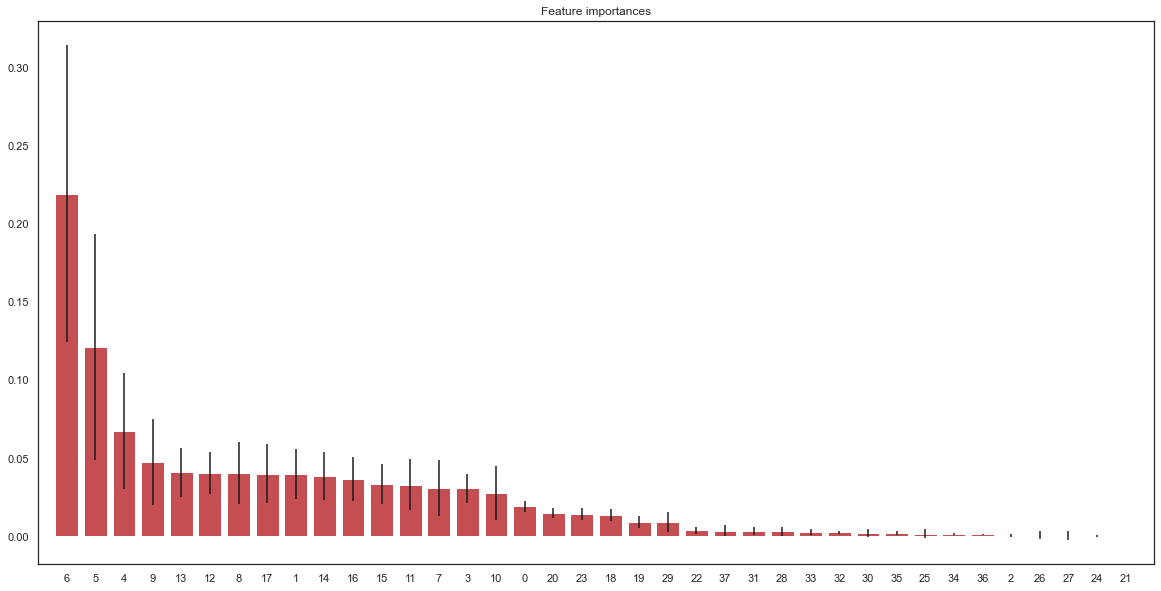

In [111]:
# 그래프로 보겠습니다.

importances = rf_hol2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_hol2.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [112]:
# 가장 중요도가 낮은 rain or not 만을 제외한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 'wind_power',
       'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_hol2_ron = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_hol2_ron.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_hol2_ron.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_hol2_ron.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_hol2_ron.score(X_train, y_train)

# 0.899716804402078
# 0.8998036397146723 소폭 상승. 이건 제출해서 적합 여부를 확인해봐얄듯.

# 	2.3705331267	그러나 실제 RMSE는 떨어짐.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.8998036397146723

In [113]:
# 위 모델의 특성 중요도 추출

print ("Features sorted by their score:")

fi = sorted(zip(map(lambda x: round(x, 4), rf_hol2_ron.feature_importances_), features), 
             reverse=True)

for i in range(len(fi)):
    print(fi[i][0], fi[i][1])

Features sorted by their score:
0.1967 10~12_on
0.1417 8~10_on
0.0662 6~8_on
0.0511 10~12_off
0.0454 bus_route_id_station_lat_long
0.0425 8~10_off
0.0411 dis_seongsan
0.0406 dis_po
0.0401 bus_route_id_station_code
0.0397 bus_route_id
0.0364 dis_jeju
0.0351 dis_gosan
0.0335 station_lat_long2
0.0318 station_code
0.0271 6~8_off
0.0247 station_lat_long
0.0192 id
0.0144 temp
0.0141 wind
0.0141 feel_temp
0.0092 rain
0.0079 date_holiday2_on
0.0035 date_holiday2_off
0.0033 wd__6
0.003 wd__0
0.0029 wd__2
0.0025 date_holiday2_poss
0.0024 wd__1
0.0022 wd__4
0.0021 dist_name_jeju
0.0018 wd__3
0.0016 wd__5
0.0009 in_out
0.0006 dist_name_po
0.0005 dist_name_seongsan
0.0003 dist_name_gosan
0.0 wind_power


In [114]:
# 가장 중요도가 낮은 rain_or_not에 wind_power도 제거한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 
       'feel_temp', 'dist_name_gosan', 'dist_name_jeju',
       'dist_name_po', 'dist_name_seongsan', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_hol2_ron_wp = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_hol2_ron_wp.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_hol2_ron_wp.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_hol2_ron_wp.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_hol2_ron_wp.score(X_train, y_train)

# 0.899716804402078
# 0.8998036397146723 ron 모델.
# 0.9002048084772074 ron-wp 모델

# 2.3760604556	위 모델보다 더 떨어짐.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9002048084772074

In [115]:
# 위 모델의 특성 중요도 추출

print ("Features sorted by their score:")

fi = sorted(zip(map(lambda x: round(x, 4), rf_hol2_ron_wp.feature_importances_), features), 
             reverse=True)

for i in range(len(fi)):
    print(fi[i][0], fi[i][1])

Features sorted by their score:
0.201 10~12_on
0.1346 8~10_on
0.0708 6~8_on
0.0521 10~12_off
0.0444 8~10_off
0.0406 bus_route_id_station_lat_long
0.0402 dis_po
0.0397 dis_seongsan
0.0396 bus_route_id
0.0382 dis_jeju
0.0374 bus_route_id_station_code
0.0354 dis_gosan
0.033 station_lat_long2
0.0305 station_code
0.0303 6~8_off
0.0252 station_lat_long
0.0195 id
0.0148 feel_temp
0.0147 wind
0.0138 temp
0.0091 date_holiday2_on
0.0089 rain
0.0035 date_holiday2_off
0.0031 wd__6
0.003 wd__2
0.003 wd__0
0.0024 wd__1
0.0023 date_holiday2_poss
0.002 wd__4
0.002 dist_name_jeju
0.0017 wd__3
0.0015 wd__5
0.0008 in_out
0.0005 dist_name_po
0.0003 dist_name_seongsan
0.0003 dist_name_gosan


In [116]:
# 가장 중요도가 낮은 rain_or_not에 wind_power에 dist3형제 제거한 모델
features=['id', 'bus_route_id', 'in_out', 'station_code', '6~8_on',
       '8~10_on', '10~12_on', '6~8_off', '8~10_off', '10~12_off',
       'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code',
       'bus_route_id_station_lat_long', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'temp', 'rain', 'wind', 
       'feel_temp','dist_name_jeju', 'date_holiday2_off',
       'date_holiday2_on', 'date_holiday2_poss', 'wd__0', 'wd__1', 'wd__2',
       'wd__3', 'wd__4', 'wd__5', 'wd__6']

# 18~20ride 를 label로 지정합니다.
label = ["18~20_ride"]

#전체 데이터로 적용
X_train=tr[features]
y_train=tr[label]
X_test=te[features]

# best_params_를 통해서 나온 값을 투입
rf_hol2_ron_wp_dist = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=100,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_hol2_ron_wp_dist.fit(X_train,y_train)

#예측값 생성 후, test['18~20_ride']에 집어 넣는다.
te['18~20_ride'] = rf_hol2_ron_wp_dist.predict(X_test)

# id와 18~20_ride만 선택 후 csv 파일로 내보낸다
te[['id','18~20_ride']].to_csv("dacon_bus_submission_rf_hol2_ron_wp_dist.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_hol2_ron_wp_dist.score(X_train, y_train)

# 0.899716804402078
# 0.8998036397146723 ron 모델.
# 0.9002048084772074 ron-wp 모델
# 0.9030724589010164 ron-wp-dist 모델

# score는 계속 올라가는데, 과연 적합도 할지
# 2.3779167967 가장 안 좋게 나옴.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9030724589010164

결과적으로 후진선택법으로 변수를 제거할 때마다 RMSE값이 올라가는 걸 알 수 있었다.

# 6. 평가:RMSE

평가 기준은 RMSE 값으로 이루어진다.

### 4.7 교통카드 데이터 머지

In [23]:
# bts데이터 전처리
def pre_bts(bus_bts):
    # bts 데이터 date로 만들어주기
    geton_datetime = []
    length = len(bus_bts["user_card_id"])

    for i in range(length):
        geton_datetime.append((str(bus_bts["geton_date"].iloc[i])+"-"+str((bus_bts['geton_time'].iloc[i]))))
    
    bus_bts["geton_datetime"] = geton_datetime
    
    # "date" 칼럼을 판다스의 datetime으로 바꿔줍니다. from 구글링.
    bus_bts["geton_datetime"] = pd.to_datetime(bus_bts["geton_datetime"], errors='coerce')
    
    # 어차피 날짜와 시간만 쓴다.
    bus_bts["geton_datetime_day"] = bus_bts["geton_datetime"].dt.day
    bus_bts["geton_datetime_hour"] = bus_bts["geton_datetime"].dt.hour
    
    # 키값을 맞추기 위해 노선을 동일하게 뒤 4자리를 없애줍니다.
    #bus_bts['bus_route_id'] = bus_bts['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    
    return bus_bts

In [24]:
def add_bts(bus_train, bus_test, bus_bts):
    # merge를 위한 key값을 만들어줍니다.
    bus_train["route_station_date"] = bus_train["bus_route_id"].astype(str)+bus_train["station_code"].astype(str)+bus_train["date"].astype(str)
    bus_test["route_station_date"] = bus_test["bus_route_id"].astype(str)+bus_test["station_code"].astype(str)+bus_test["date"].astype(str)
    bus_bts["route_station_date"] = bus_bts["bus_route_id"].astype(str)+bus_bts["geton_station_code"].astype(str)+bus_bts["geton_date"].astype(str)

    # bts의 user_category를 만들어준다.
    merge1 = bus_bts.groupby(["route_station_date", "user_category"], sort=False)["user_count"].count().unstack().add_prefix("user_").reset_index()
    merge1.fillna(value=0, inplace=True)
    merge1["user_old"] = merge1["user_6"]+merge1["user_27"]+merge1["user_28"]+merge1["user_29"]+merge1["user_30"]
    merge1 = merge1.drop(["user_6", "user_27", "user_28", "user_29", "user_30"], axis=1)
    merge1 = merge1.rename(columns={"user_1":"user_adult", "user_2":"user_kid", "user_4":"user_youth"})
    
    # ratio를 잡아줍니다.
    merge1["total"] = merge1["user_adult"] + merge1["user_kid"] + merge1["user_old"] + merge1["user_youth"]
    merge1["adult_ratio"] = round((merge1["user_adult"] / merge1["total"]), 2)
    merge1["youth_ratio"] = round((merge1["user_youth"] / merge1["total"]), 2)
    # bts의 on 트랜잭션을 만들어준다.
    #merge2 = bus_bts.groupby(["route_station_date", "geton_datetime_hour"], sort=False)["user_count"].count().unstack().add_prefix("trx_").reset_index()
    #merge2.fillna(value=0, inplace=True)
    #merge2["6~8_trx"] = merge2["trx_6"]+merge2["trx_7"]
    #merge2["8~10_trx"] = merge2["trx_8"]+merge2["trx_9"]
    #merge2["10~12_trx"] = merge2["trx_10"]+merge2["trx_11"]
    #merge2 = merge2.drop(["trx_6","trx_7","trx_9","trx_8","trx_10","trx_11"],axis=1)
    
    # 두 데이터를 합치고.
    #merge_all=pd.merge(merge2,merge1,how='left',on=['route_station_date'])
    
    # 각각 tr, te에 머지해준다.
    bus_train=pd.merge(bus_train,merge1,how='left',on=['route_station_date'])
    bus_test=pd.merge(bus_test,merge1,how='left',on=['route_station_date'])
  
    bus_train.drop(["route_station_date"], axis=1, inplace=True)
    bus_test.drop(["route_station_date"], axis=1, inplace=True)
    
    return bus_train, bus_test

In [25]:
def fill_na(bus_train, bus_test):
    #bus_train["6~8_trx"].fillna(value=0, inplace=True)
    #bus_train["8~10_trx"].fillna(value=0, inplace=True)
    #bus_train["10~12_trx"].fillna(value=0, inplace=True)
    bus_train["user_adult"].fillna(value=0, inplace=True)
    bus_train["user_youth"].fillna(value=0, inplace=True)
    bus_train["user_kid"].fillna(value=0, inplace=True)
    bus_train["user_old"].fillna(value=0, inplace=True)

    #bus_test["6~8_trx"].fillna(value=0, inplace=True)
    #bus_test["8~10_trx"].fillna(value=0, inplace=True)
    #bus_test["10~12_trx"].fillna(value=0, inplace=True)
    bus_test["user_adult"].fillna(value=0, inplace=True)
    bus_test["user_youth"].fillna(value=0, inplace=True)
    bus_test["user_kid"].fillna(value=0, inplace=True)
    bus_test["user_old"].fillna(value=0, inplace=True)
    
    return bus_train, bus_test